In [1]:
################################################################################
#                                                                              #
#                         Author: Bc. Petr Pouč                                #
#                         Date: April 4, 2024                                  #
#                         School: Brno University of Technology (BUT)          #
#                                                                              #
#         Master's Thesis: Optimization of Classification Models               #
#                         for Malicious Domain Detection                       #
#                                                                              #
################################################################################

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import pickle
from tqdm.notebook import tqdm 
import pyarrow as pa
import pyarrow.parquet as pq
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import sys
sys.path.append('..')
from utils.preprocess_one_domain import NDF

2024-05-14 21:04:20.479500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Loading and Preprocessing

In [2]:
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 15


#The whole preprocessing step happens here
#Missing values set to -1
#Outliers are removed
#Encoding of categorical variables
#Min-Max scaling, sigmoid transformation (only if cnn is used)
input_data = {
    'benign': '../floor/benign_2312.parquet',
    'malign': '../floor/phishing_2311.parquet'
}
dataset = NDF("cnn", True, input_data=input_data, one_line_processing=False)
print(dataset['feature_names'])


2024-05-14 21:04:26,583 - utils.preprocess_one_domain - INFO - Benign dataset path: ../floor/benign_2312.parquet
2024-05-14 21:04:26,586 - utils.preprocess_one_domain - INFO - Malign dataset path: ../floor/phishing_2311.parquet


Malign dataset path: ../floor/phishing_2311.parquet
Benign dataset path: ../floor/benign_2312.parquet


2024-05-14 21:04:27,526 - utils.preprocess_one_domain - INFO - Number of records in benign dataset: 432572
2024-05-14 21:04:27,530 - utils.preprocess_one_domain - INFO - Number of records in malign dataset: 68353
2024-05-14 21:04:30,123 - utils.preprocess_one_domain - INFO - Total percentage of missing values in benign dataset: 0.39%
2024-05-14 21:04:30,126 - utils.preprocess_one_domain - INFO - Total percentage of missing values in malign dataset: 0.45%
2024-05-14 21:04:40,717 - utils.preprocess_one_domain - INFO - Decision tree model saved to trained_borders/decision_tree_model.joblib
2024-05-14 21:04:40,762 - utils.preprocess_one_domain - INFO - New feature 'dtree_prob' created from decision tree predictions.
2024-05-14 21:04:40,860 - utils.preprocess_one_domain - INFO - Decision Tree Train Accuracy: 0.94
2024-05-14 21:04:40,862 - utils.preprocess_one_domain - INFO - Decision Tree Test Accuracy: 0.92
2024-05-14 21:04:42,224 - utils.preprocess_one_domain - INFO - Decision Tree Cross-


Dataset Subset:
Name: dataset_../floor/benign2312_../floor/phishing2311_2024-05-14.parquet
Features:
   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0        0.5   0.500000   0.500000        0.5   0.500000   0.500000   
1        0.5   0.500000   0.500000        0.5   0.500000   0.500000   
2        0.5   0.519221   0.531209        0.5   0.500000   0.500000   
3        0.5   0.500000   0.500000        0.5   0.557438   0.500000   
4        0.5   0.519221   0.500000        0.5   0.500000   0.500000   
5        0.5   0.500000   0.500000        0.5   0.500000   0.500000   
6        0.5   0.500000   0.500000        0.5   0.613379   0.510415   
7        0.5   0.519221   0.500000        0.5   0.500000   0.500000   
8        0.5   0.500000   0.500000        0.5   0.500000   0.500000   
9        0.5   0.519221   0.500000        0.5   0.500000   0.500000   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_169  Feature_170  \
0   0.500000   0.731059   0.500000  

In [3]:
# # Define the Balanced-SMOTE pipeline
# # For RandomUnderSampler, 'sampling_strategy' is also set to 'auto' which undersamples the majority class
# over = SMOTE(sampling_strategy=0.5, random_state=42)  # Adjust as needed
# under = RandomUnderSampler(sampling_strategy=0.8, random_state=42)  
# pipeline = Pipeline([
#     ('over', over), 
#     ('under', under)
# ])

# # Apply the Balanced-SMOTE pipeline
# x_train_balanced, y_train_balanced = pipeline.fit_resample(x_train, y_train)

# # Check and print the new class distribution
# new_label_counts = Counter(y_train_balanced)
# print("New class distribution after Balanced-SMOTE:")
# for label, count in new_label_counts.items():
#     print(f"Class {label}: {count}")

# # Convert the balanced data to PyTorch tensors for model training
# x_train = torch.tensor(x_train_balanced, dtype=torch.float32)
# y_train = torch.tensor(y_train_balanced, dtype=torch.long)
# x_test = torch.tensor(x_test, dtype=torch.float32)  # Ensure x_test is converted to tensor as well
# y_test = torch.tensor(y_test, dtype=torch.long)

# # Determine the number of features for model input (useful for defining network architecture)
# feature_size = x_train.shape[1]

## Smote Class Imbalance Handling

In [4]:
from collections import Counter
#imprt SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


# Calculate class weights
# label_counts = Counter(y_train.numpy())
# total_count = len(y_train)
# class_weights = {class_id: total_count / count for class_id, count in label_counts.items()}
# weights = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float)

# # Print class weights
# print("Class weights calculated as follows:")
# for label, weight in class_weights.items():
#     print(f"Class {int(label)}: Weight {weight:.2f}")

# # Weighted loss function
# ##adjusts how the model perceives the importance of each class during the training process 

# criterion = nn.CrossEntropyLoss(weight=weights)

# # Check shapes and label distribution
# print("Feature Names (if available):", dataset.get('feature_names', []))  # Adjust based on actual key availability
# print("Training data shape:", x_train.shape)
# print("Training labels distribution:", y_train.unique(return_counts=True))
x_train, x_test, y_train, y_test = train_test_split(np.array(dataset['features']), np.array(dataset['labels']), test_size=0.2, random_state=42)



# Apply SMOTE
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# Check the new class distribution
new_label_counts = Counter(y_train_smote)
print("New class distribution after SMOTE:")
for label, count in new_label_counts.items():
    print(f"Class {label}: {count}")

# Convert the data to PyTorch tensors
x_train = torch.tensor(x_train_smote, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)  # Convert x_test to tensor
y_train = torch.tensor(y_train_smote, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long) 
feature_size = x_train.shape[1]


New class distribution after SMOTE:
Class 0.0: 32699
Class 1.0: 32699


## Data Alignment

In [5]:
import torch.nn.functional as F
import math

# Function to calculate the next perfect square greater than a given number
def next_perfect_square(n):
    next_square = math.ceil(n**0.5)**2
    return next_square

# Calculate the side size for the square shape dynamically
# feature_size = x_train.shape[1]  # Number of features in your dataset
# desired_size = next_perfect_square(feature_size)  # Next perfect square
# side_size = int(desired_size**0.5)  # Side size of the square

# # Calculate padding required to achieve the desired size
# padding = desired_size - feature_size

# # Applying dynamic padding
# if padding > 0:
#     # The padding is applied to the last dimension of the dataset
#     # (0, padding) applies the padding only to the right side of the last dimension
#     x_train_padded = F.pad(x_train, (0, padding), 'constant', 0)
#     x_test_padded = F.pad(x_test, (0, padding), 'constant', 0)
# else:
#     # If no padding is needed, use the original data
#     x_train_padded = x_train
#     x_test_padded = x_test

# # Reshape the data to the new dynamically calculated square shape
# x_train = x_train_padded.view(-1, 1, side_size, side_size)
# x_test = x_test_padded.view(-1, 1, side_size, side_size)

feature_size = x_train.shape[1]
desired_size = next_perfect_square(feature_size)
side_size = int(desired_size ** 0.5)

# Calculate padding required to achieve the desired size
padding = desired_size - feature_size

# Applying dynamic padding
if padding > 0:
    x_train_padded = F.pad(x_train, (0, padding), 'constant', 0)
    x_test_padded = F.pad(x_test, (0, padding), 'constant', 0)
else:
    x_train_padded = x_train
    x_test_padded = x_test

# Reshape the data to the new dynamically calculated square shape
x_train = x_train_padded.view(-1, 1, side_size, side_size)
x_test = x_test_padded.view(-1, 1, side_size, side_size)

## CNN Architecture

In [6]:
class Net(nn.Module):
    def __init__(self, side_size):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        
        self.fc1 = nn.Linear(64 * (side_size-4)**2, 1024)
        
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 2)
        print("CNN model created")


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return self.fc4(x)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model's training

In [8]:
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 2

# Initialize model, load CNN or NN model

# model = CNet(side_size=side_size).to(device) # convolutional model
model = Net(side_size).to(device) # classic fully connected model

###########################################

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Prepare DataLoader
train_data = TensorDataset(x_train, y_train.long())
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# Function to compute accuracy and F1 score
def compute_metrics(data_loader, model):
    model.eval()
    true_labels = []
    predictions = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)  # Move data to the device
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            true_labels.extend(target.cpu().tolist())  # Move data back to CPU for scoring
            predictions.extend(pred.view_as(target).cpu().tolist())  # Move data back to CPU

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    return accuracy, f1

epoch_losses = []
epoch_accuracies = []
epoch_f1s = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)  # Move data to the device
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Compute average loss
    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)

    # Evaluate model and store metrics
    train_accuracy, train_f1 = compute_metrics(train_loader, model)
    epoch_accuracies.append(train_accuracy)
    epoch_f1s.append(train_f1)

    # Enhanced logging
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}")


# Save the model
torch.save(model.state_dict(), './phishing_cnn_model.pth')
print("Model training complete and saved.")

# Load the model
model = Net(side_size)
model.load_state_dict(torch.load('./phishing_cnn_model.pth'))
model.eval()

# Make predictions on the test set
predictions = model(x_test).argmax(dim=1)

CNN model created


Epoch 1/2 - Loss: 0.2348, Accuracy: 0.9473, F1 Score: 0.9459
Epoch 2/2 - Loss: 0.1248, Accuracy: 0.9531, F1 Score: 0.9518
Model training complete and saved.
CNN model created


## Model's evaluation

CNN model created

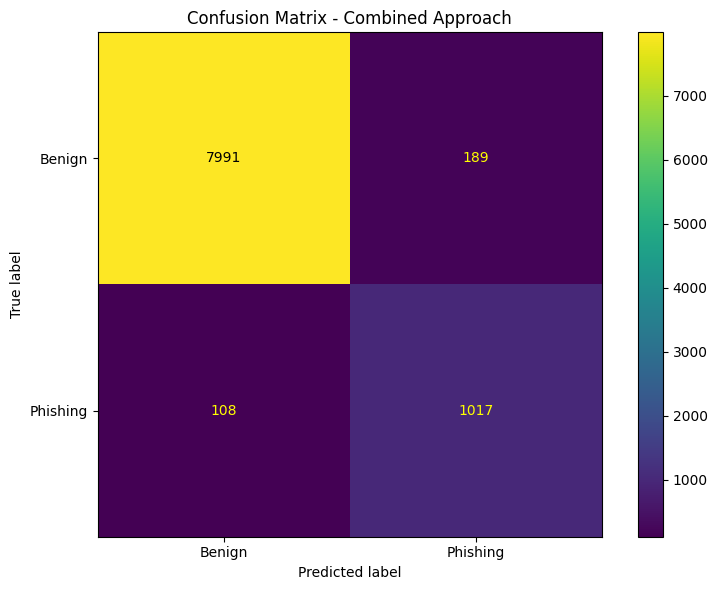

Best F1 Score: 0.9518
Best Accuracy: 0.9531


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Load the model
model = Net(side_size)
model.load_state_dict(torch.load('./phishing_cnn_model.pth'))
model.eval()

# Make predictions on the test set
predictions = model(x_test).argmax(dim=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='viridis')
plt.title('Confusion Matrix - Combined Approach')
plt.colorbar()

classes = ['Benign', 'Phishing']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 ha="center", va="center",
                 color="black" if conf_matrix[i, j] > thresh else "yellow")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confusion_matrix_smote.png', dpi=500, bbox_inches='tight', pad_inches=0.5)
plt.show()

# Get the best F1 score and accuracy from the model and print them
best_f1_score = max(epoch_f1s)
best_accuracy = max(epoch_accuracies)
print(f"Best F1 Score: {best_f1_score:.4f}")
print(f"Best Accuracy: {best_accuracy:.4f}")


## Models evaluation

In [11]:
import torch
from sklearn.metrics import accuracy_score, f1_score

# Assuming you have these already imported
# from torch.utils.data import DataLoader, TensorDataset

def evaluate_model(model_path, test_data, test_labels, batch_size=64, device='cpu'):
    model = Net(side_size)  # or CNet(side_size) for convolutional
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    test_dataset = TensorDataset(test_data, test_labels.long())
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    true_labels = []
    predictions = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # Move data to the device
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            true_labels.extend(target.cpu().tolist())  # Move data back to CPU for scoring
            predictions.extend(pred.view_as(target).cpu().tolist())  # Move data back to CPU

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

# Example usage
model_path = './phishing_cnn_model.pth'
evaluate_model(model_path, x_test, y_test)


CNN model created
Test Accuracy: 0.9681
Test F1 Score: 0.9686


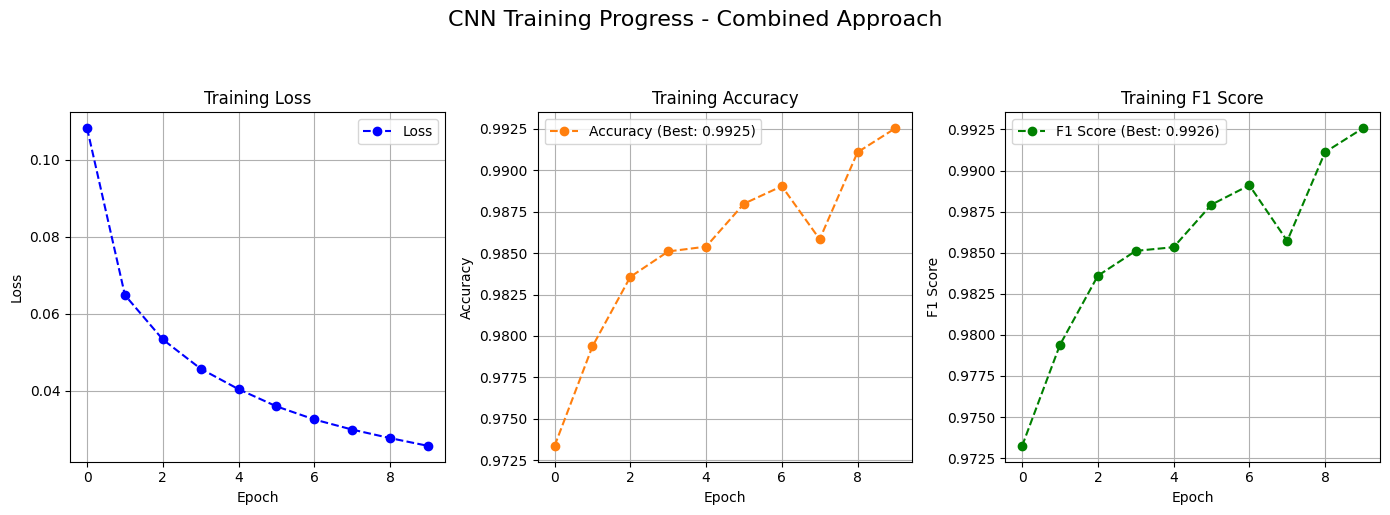

In [ ]:
import matplotlib.pyplot as plt

# Assuming epoch_losses, epoch_accuracies, and epoch_f1s are defined, along with best_accuracy and best_f1_score
plt.figure(figsize=(14, 5))

# Plot for Loss
plt.subplot(1, 3, 1)
plt.plot(epoch_losses, linestyle='--', marker='o', color='b', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot for Accuracy
plt.subplot(1, 3, 2)
plt.plot(epoch_accuracies, linestyle='--', marker='o', color='#ff7f0e', label=f'Accuracy (Best: {best_accuracy:.4f})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)

# Plot for F1 Score
plt.subplot(1, 3, 3)
plt.plot(epoch_f1s, linestyle='--', marker='o', color='g', label=f'F1 Score (Best: {best_f1_score:.4f})')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training F1 Score')  # Added title for the F1 Score plot
plt.legend()
plt.grid(True)


plt.suptitle('CNN Training Progress - Combined Approach', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjusted layout to accommodate the suptitle properly
#svae fig
plt.savefig('cnn_combined_last.png', dpi=500, bbox_inches='tight', pad_inches=0.5)
plt.show()

## Analýza dat

### Načtení dat
- **Benigní dataset (1. měření):** `pq.read_table('floor/benign_2310.parquet')`
- **Phishing dataset (1. měření):** `pq.read_table('floor/phishing_2307.parquet')` - Rozměry: 432572 x 36993 (758, 263)

### Výsledky (1. měření)
- **F1 skóre:** 0.9529514768904658
- **Accuracy:** 0.9928

|           | precision | recall | f1-score | support |
|-----------|-----------|--------|----------|---------|
| **0**     | 0.9942    | 0.9980 | 0.9961   | 129772  |
| **1**     | 0.9752    | 0.9317 | 0.9530   | 11098   |

---

### Načtení dat
- **Benigní dataset (2. měření):** `pq.read_table('floor/inputs-for-petr/benign_2312.parquet')`
- **Phishing dataset (2. měření):** `pq.read_table('floor/phishing_2307.parquet')` - Rozměry: 432572 x 36993 (496, 212)

### Výsledky (2. měření)
- **F1 skóre:** 0.9676889375684556
- **Accuracy:** 0.9950

|           | precision | recall | f1-score | support |
|-----------|-----------|--------|----------|---------|
| **0**     | 0.9962    | 0.9984 | 0.9973   | 129772  |
| **1**     | 0.9804    | 0.9553 | 0.9677   | 11098   |

---

### Načtení dat
- **Benigní dataset (3. měření):** `pq.read_table('floor/inputs-for-petr/benign_2312.parquet')`
- **Phishing dataset (3. měření):** `pq.read_table('floor/inputs-for-petr/phishing_2311.parquet')` - Rozměry: 432572 x 68353 (793, 280)

### Výsledky (3. měření)
- **F1 skóre:** 0.9735055186547816
- **Accuracy:** 0.9929

|           | precision | recall | f1-score | support |
|-----------|-----------|--------|----------|---------|
| **0**     | 0.9939    | 0.9978 | 0.9959   | 129772  |
| **1**     | 0.9860    | 0.9613 | 0.9735   | 20506   |


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
from sklearn.metrics import roc_auc_score

def compute_metrics(data_loader, model, criterion):
    """
    Computes a wide range of performance metrics for the given model evaluated on the provided DataLoader.
    
    Parameters:
        data_loader (DataLoader): DataLoader for evaluation data.
        model (torch.nn.Module): The neural network model to evaluate.
        criterion (torch.nn.Module): Loss function used for the model.
    
    Returns:
        dict: A dictionary containing various performance metrics.
    """
    model.eval()  # Switch model to evaluation mode
    true_labels, predictions, probs, losses = [], [], [], []

    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            loss = criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            prob = torch.nn.functional.softmax(output, dim=1)[:,1]  # Probability for class 1
            true_labels.extend(target.cpu().numpy())
            predictions.extend(pred.cpu().view_as(target).numpy())
            probs.extend(prob.cpu().numpy())
            losses.append(loss.item())
    
    # Compute metrics
    metrics = {
        'accuracy': accuracy_score(true_labels, predictions),
        'f1': f1_score(true_labels, predictions, average='weighted'),
        'precision': precision_score(true_labels, predictions, average='weighted', zero_division=0),
        'recall': recall_score(true_labels, predictions, average='weighted', zero_division=0),
        'roc_auc_score': roc_auc_score(true_labels, probs) if len(np.unique(true_labels)) > 1 else 0,
        'cross_entropy_loss': np.mean(losses),
    }
    
    return metrics

def evaluate_model(model, x_test, y_test, batch_size, criterion):
    """
    Evaluates the model on the test dataset and prints out a comprehensive set of performance metrics.
    
    Parameters:
        model (torch.nn.Module): The neural network model to evaluate.
        x_test (Tensor): Test dataset features.
        y_test (Tensor): Test dataset labels.
        batch_size (int): Batch size for data loading.
        criterion (torch.nn.Module): Loss function used for the model.
    """
    test_data = TensorDataset(x_test, y_test.long())
    test_loader = DataLoader(test_data, batch_size=batch_size)
    
    metrics = compute_metrics(test_loader, model, criterion)
    
    # Display the metrics
    print("Test Metrics:")
    for metric_name, metric_value in metrics.items():
        if metric_name == 'confusion_matrix':
            print(f"{metric_name}:\n{metric_value}\n")
        else:
            print(f"{metric_name}: {metric_value:.4f}")
    
    return metrics

# Assuming criterion is defined (e.g., nn.CrossEntropyLoss())
criterion = torch.nn.CrossEntropyLoss()

# Example of how to use the evaluate_model function:
# model = Net()  # Assume Net is defined elsewhere and is your trained model
metrics = evaluate_model(model, x_test, y_test, BATCH_SIZE, criterion)


Test Metrics:
accuracy: 0.9836
f1: 0.9838
precision: 0.9843
recall: 0.9836
roc_auc_score: 0.9964
cross_entropy_loss: 0.0549


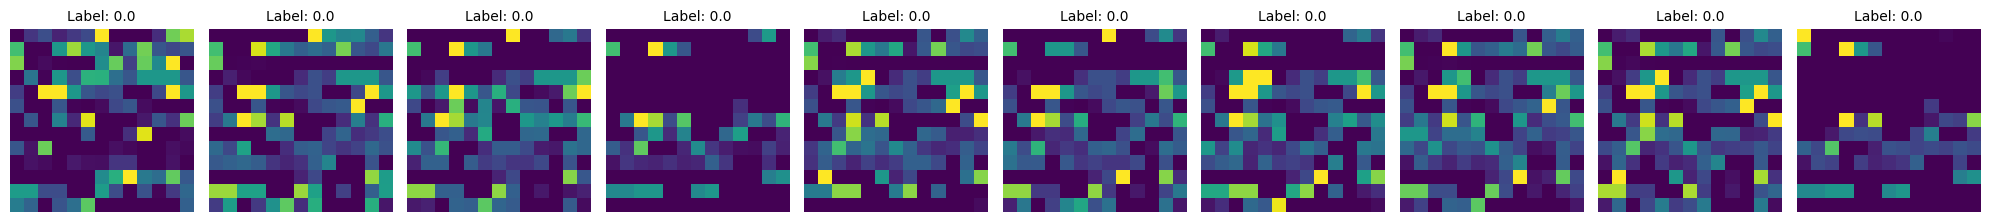

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dataset_with_labels(dataset, num_samples=10):
    indices = np.random.choice(len(dataset['features']), num_samples, replace=False)
    features = dataset['features'][indices]
    labels = dataset['labels'][indices]
    feature_size = features.shape[1]
    side_length = int(np.sqrt(feature_size))
    if side_length * side_length != feature_size:
        print(f"Warning: Feature size {feature_size} is not a perfect square. Adjusting to closest square.")
        adjusted_size = side_length * side_length

    # Adjust figsize and add dpi for higher resolution
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4), dpi=100)  # Increased dpi for better quality

    for i in range(num_samples):
        image = features[i][:adjusted_size].reshape(side_length, side_length)
        axes[i].imshow(image, cmap='viridis')  # Changed colormap for better visual appeal
        axes[i].axis('off')
        axes[i].set_title(f"Label: {labels[i]}", fontsize=10)  # Increased font size

    plt.tight_layout()
    plt.show()

visualize_dataset_with_labels(dataset)


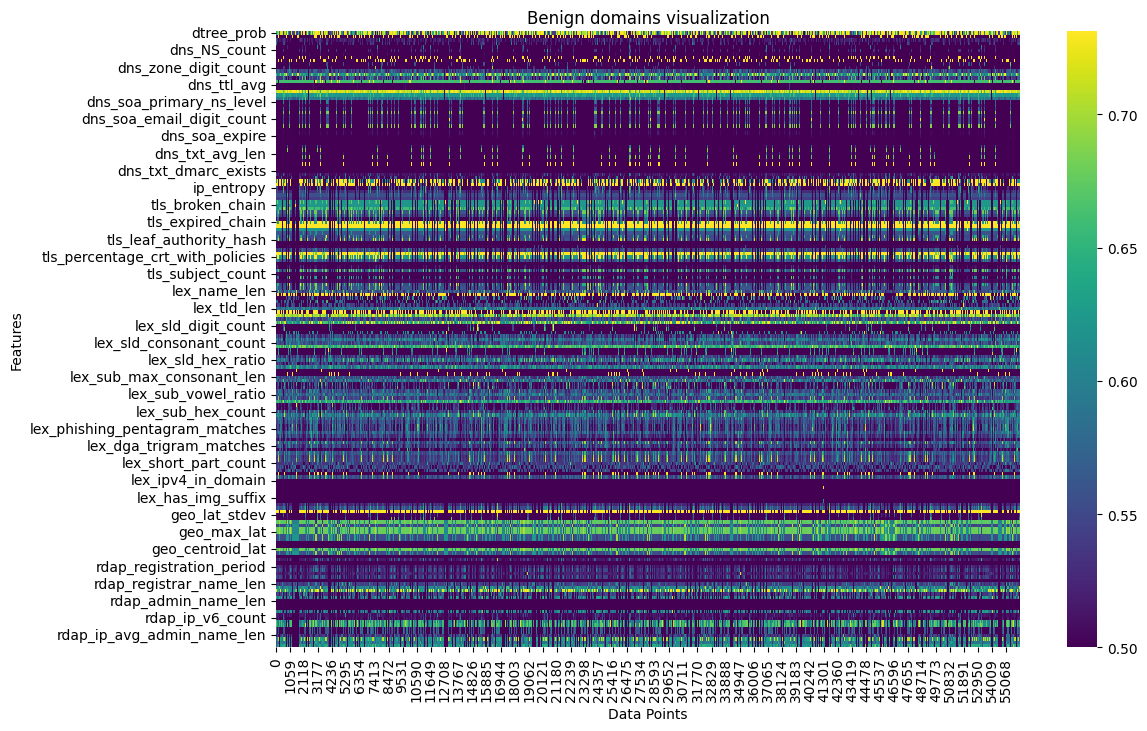

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def visualize_dataset_matrix(dataset, label=0):
    """
    Visualizes the dataset as a matrix using a heatmap.

    :param dataset: The dataset containing features.
    """
    features = dataset['features']
    feature_names = dataset['feature_names']
    labels = dataset['labels']
    name = "Malware domains"
    
    if label != 0:
        indices = np.where(labels == label)[0]
        features = features[indices]
        name = "Benign domains"

    # Convert to DataFrame for easier plotting
    df = pd.DataFrame(features, columns=feature_names)

    # Check if 'dtree_prob' is in the columns, and if so, move it to the front
    if 'dtree_prob' in df.columns:
        # Move 'dtree_prob' to the first column
        cols = ['dtree_prob'] + [col for col in df if col != 'dtree_prob']
        df = df[cols]

    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(df.T, cmap='viridis')
   
    # rotate the axis )
    plt.title(name + ' visualization')
    plt.ylabel('Features')
    plt.xlabel('Data Points')
    
    # save plot as png to current directory in high resolution with white margin 
    plt.savefig(name + '_visualization.png', dpi=500, bbox_inches='tight', pad_inches=1)
    

    plt.show()

# Assuming 'dataset' is your loaded dataset
visualize_dataset_matrix(dataset, label=1)
# visualize_dataset_matrix(dataset, label=0)


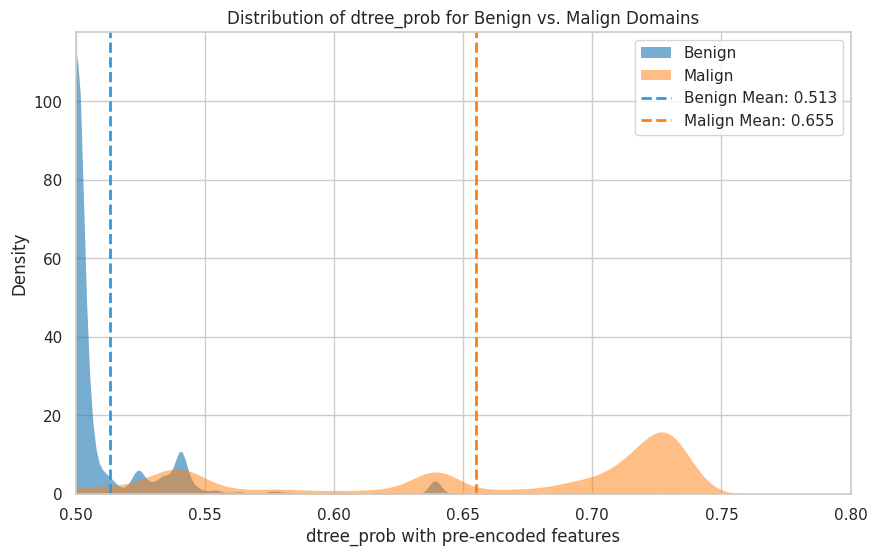

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def visualize_dtree_prob_with_vibrant_colors(dataset):
    """
    Visualizes the 'dtree_prob' feature for benign and malign domains with smoothed density curves,
    vibrant orange and blue colors, and mean lines for easier comparison between the two datasets.
    
    :param dataset: The dataset containing features and labels.
    """
    # Convert dataset to DataFrame
    df = pd.DataFrame(dataset['features'], columns=dataset['feature_names'])
    df['label'] = dataset['labels']  # Assuming 0 for benign, 1 for malign
    
    # For easier interpretation, convert labels from 0,1 to 'Benign', 'Malign'
    df['label'] = df['label'].map({0: 'Benign', 1: 'Malign'})

    # Setting up the figure and axis for the plot with improved aesthetics
    plt.figure(figsize=(10, 6))
    # Set the style of the plot to 'whitegrid' for a clean, academic look
    sns.set_theme(style='whitegrid')  # Updated method to set style

    # Advanced distribution plot with vibrant orange and blue colors and smoother curves
    sns.kdeplot(data=df[df['label'] == 'Benign'], x='dtree_prob', fill=True, color="#1f77b4", alpha=0.6, linewidth=0, label='Benign', bw_adjust=1.0)
    sns.kdeplot(data=df[df['label'] == 'Malign'], x='dtree_prob', fill=True, color="#ff7f0e", alpha=0.5, linewidth=0, label='Malign', bw_adjust=1.0)

    # Calculating means
    benign_mean = df[df['label'] == 'Benign']['dtree_prob'].mean()
    malign_mean = df[df['label'] == 'Malign']['dtree_prob'].mean()

    # Adding mean lines with vibrant colors
    plt.axvline(benign_mean, color="#3498db", linestyle='--', linewidth=2, label=f'Benign Mean: {benign_mean:.3f}')
    plt.axvline(malign_mean, color="#ff7f0e", linestyle='--', linewidth=2, label=f'Malign Mean: {malign_mean:.3f}')

    plt.title('Distribution of dtree_prob for Benign vs. Malign Domains')
    plt.xlabel('dtree_prob with pre-encoded features')
    plt.ylabel('Density')

    # Stretching the x-axis to have a max value of 0.8
    plt.xlim([df['dtree_prob'].min(), 0.8])

    # Adding a legend with improved aesthetics
    plt.legend(title_fontsize='13', labelspacing=0.5)

    # Show the plot
    #savefig
    plt.savefig('dtree_prob_distribution_preencoded.png', dpi=800, bbox_inches='tight', pad_inches=0.5)
    plt.show()

# Assuming 'dataset' is your loaded dataset
visualize_dtree_prob_with_vibrant_colors(dataset)



